salp_passage_3a-mlp: 1 trials


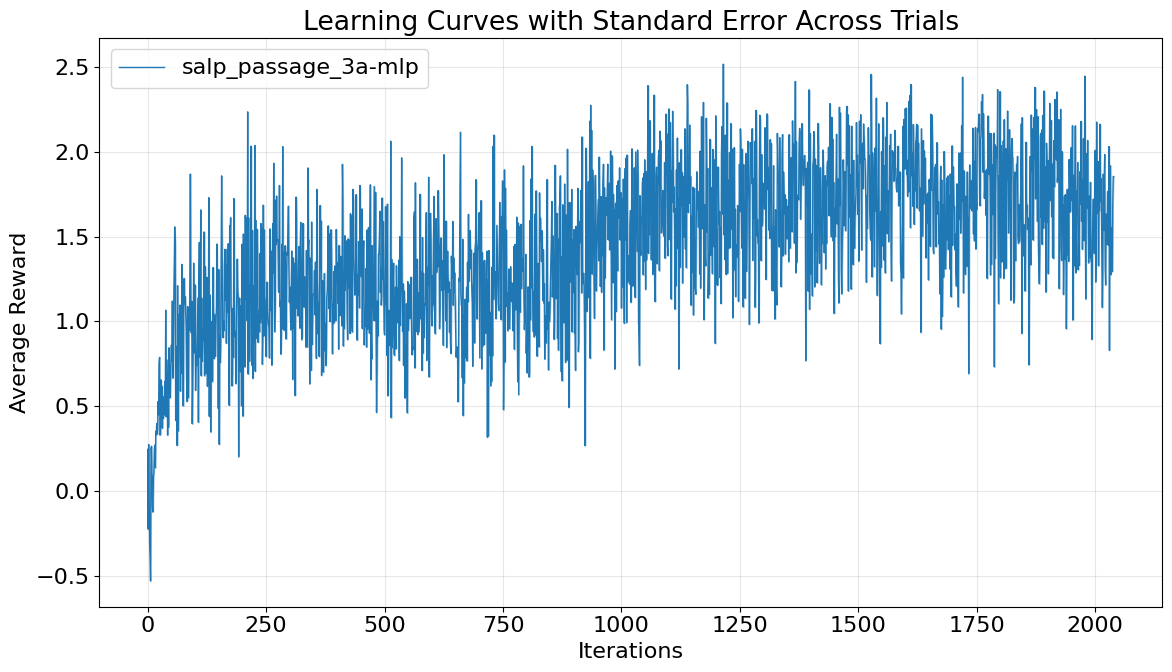

In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
import numpy as np
import pickle
import yaml

plt.rcParams.update({'font.size': 16})

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plotting_dir = Path().resolve()
config_dir = plotting_dir / "ppo_config.yaml"

with open(config_dir, "r") as file:
    config = yaml.safe_load(file)

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

# Store data by experiment group
experiment_data = defaultdict(list)
max_len = 0

# First pass: collect data for each experiment
for batch in config["batches"]:
    for experiment in config["experiments"]:
        exp_key = f"{batch}-{experiment}"
        
        for trial in config["trials"]:
            checkpoint_path = Path(f"{config['base_path']}/{batch}/{experiment}/{trial}/logs/train.dat")

            if checkpoint_path.is_file():
                with open(checkpoint_path, "rb") as handle:
                    data = pickle.load(handle)["rewards_per_iteration"][:config["datapoints"][0]]

                    
                    # Apply moving average
                    if len(data) > config["moving_avg_window_size"]:
                        smoothed_data = moving_average(data, config["moving_avg_window_size"])
                        experiment_data[exp_key].append(smoothed_data)
                        max_len = max(max_len, len(smoothed_data))
                    else:
                        print(f"Warning: Trial {trial} has too few data points for smoothing")

# Second pass: pad arrays to the same length if needed
for exp_key in experiment_data:
    padded_data = []
    for trial_data in experiment_data[exp_key]:
        if len(trial_data) < max_len:
            # Pad with last value or NaN
            padding = np.full(max_len - len(trial_data), np.nan)
            padded_data.append(np.concatenate([trial_data, padding]))
        else:
            padded_data.append(trial_data)
    
    experiment_data[exp_key] = padded_data

# Plotting with standard error
color_idx = 0
for exp_key in experiment_data:
    if not experiment_data[exp_key]:
        print(f"No data for {exp_key}")
        continue
        
    # Convert list of arrays to 2D numpy array
    data_array = np.array(experiment_data[exp_key])
    
    # Calculate mean and standard error across trials
    mean_rewards = np.nanmean(data_array, axis=0)
    
    # Standard Error = StdDev / sqrt(n)
    n_trials = np.sum(~np.isnan(data_array), axis=0)  # Count non-NaN values at each step
    std_rewards = np.nanstd(data_array, axis=0)
    se_rewards = std_rewards / np.sqrt(np.maximum(n_trials, 1))  # Avoid division by zero
    
    # X axis
    x = np.arange(len(mean_rewards))
    
    # Get color for this experiment
    color = plt.cm.tab10(color_idx % 10)
    color_idx += 1
    
    # Plot mean line
    ax.plot(x, mean_rewards, linewidth=1, label=exp_key, color=color)
    
    # Plot standard error band
    ax.fill_between(
        x,
        mean_rewards - se_rewards,
        mean_rewards + se_rewards,
        alpha=0.3,
        color=color
    )
    
    print(f"{exp_key}: {len(experiment_data[exp_key])} trials")

ax.legend(loc='best')
ax.set_xlabel("Iterations")
ax.set_ylabel("Average Reward")
ax.set_title("Learning Curves with Standard Error Across Trials")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()